In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
#This is just whats ready locally on my machine
df =  pd.read_csv('/Users/farhanhabibie/Desktop/Uni Stage 3/Introduction to AI/intro-to-ai-farhan-labi/covid_19_indonesia_time_series_all.csv')

In [4]:
#See what dataframe looks like
df

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,City or Regency,Province,Country,Continent,Island,Time Zone,Special Status,Total Regencies,Total Cities,Total Districts,Total Urban Villages,Total Rural Villages,Area (km2),Population,Population Density,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.60,0.00,1.84,0.18,51.28%,105.13%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.78,0.00,1.84,0.18,48.78%,100.00%,1.00,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,2,Country,NaN,NaN,Indonesia,Asia,NaN,NaN,NaN,416,98.0,7230,8488.0,74953.0,1916907,265185520,138.34,113.921327,-0.789275,0.01,0.01,0.00,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,2,0,3,-1,Province,NaN,Riau,Indonesia,Asia,Sumatera,UTC+07:00,NaN,10,2.0,169,268.0,1591.0,87024,6074100,69.80,101.805109,0.511648,0.16,0.33,0.00,0.00,0.00,0.00%,150.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,NaN,DKI Jakarta,Indonesia,Asia,Jawa,UTC+07:00,Daerah Khusus Ibu Kota,1,5.0,44,267.0,NaN,664,10846145,16334.31,106.836118,-6.204699,0.18,3.96,0.00,1.84,0.18,46.51%,95.35%,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21754,12/2/2021,ID-SA,Sulawesi Utara,2,0,0,2,34715,1056,33566,93,Province,NaN,Sulawesi Utara,Indonesia,Asia,Sulawesi,UTC+08:00,NaN,11,4.0,171,332.0,1507.0,13892,2641884,190.17,124.521240,1.259638,0.76,13140.24,0.00,399.71,39.97,3.04%,96.69%,NaN,1.0
21755,12/2/2021,ID-SB,Sumatera Barat,4,0,0,4,89849,2152,87605,92,Province,NaN,Sumatera Barat,Indonesia,Asia,Sumatera,UTC+07:00,NaN,12,7.0,179,230.0,928.0,42013,5519245,131.37,100.465062,-0.850253,0.72,16279.22,0.00,389.91,38.99,2.40%,97.50%,4.00,1.0
21756,12/2/2021,ID-SS,Sumatera Selatan,4,0,0,4,59937,3071,56830,36,Province,NaN,Sumatera Selatan,Indonesia,Asia,Sumatera,UTC+07:00,NaN,13,4.0,241,387.0,2853.0,91592,8217551,89.72,104.169465,-3.216212,0.49,7293.78,0.00,373.71,37.37,5.12%,94.82%,4.00,1.0
21757,12/2/2021,ID-SU,Sumatera Utara,4,0,1,3,106045,2889,103061,95,Province,NaN,Sumatera Utara,Indonesia,Asia,Sumatera,UTC+07:00,NaN,25,8.0,450,693.0,5417.0,72981,14874889,203.82,99.051964,2.191894,0.27,7129.13,0.00,194.22,19.42,2.72%,97.19%,1.00,1.0


In [5]:
#Checking for any null values
print(df.isnull().any())

Date                           False
Location ISO Code              False
Location                       False
New Cases                      False
New Deaths                     False
New Recovered                  False
New Active Cases               False
Total Cases                    False
Total Deaths                   False
Total Recovered                False
Total Active Cases             False
Location Level                 False
City or Regency                 True
Province                        True
Country                        False
Continent                      False
Island                          True
Time Zone                       True
Special Status                  True
Total Regencies                False
Total Cities                    True
Total Districts                False
Total Urban Villages            True
Total Rural Villages            True
Area (km2)                     False
Population                     False
Population Density             False
L

In [6]:
#Create a copy of the dataset to work on
df_regression = df.copy()

In [7]:
#Set date as index this just makes the df easier to work with
df_regression = df_regression.set_index('Date')

In [8]:
#For the NA values that are in int columns, fill them with medians 
med_gf_nc = df_regression['Growth Factor of New Cases'].median()
med_gf_nd = df_regression['Growth Factor of New Deaths'].median()
med_tot_uv = df_regression['Total Urban Villages'].median()
med_tot_rv = df_regression['Total Rural Villages'].median()
med_tot_c = df_regression['Total Cities'].median()

df_regression['Growth Factor of New Cases'] = df_regression['Growth Factor of New Cases'].fillna(med_gf_nc)

df_regression['Growth Factor of New Deaths'] = df_regression['Growth Factor of New Deaths'].fillna(med_gf_nd)

df_regression['Total Urban Villages'] = df_regression['Total Urban Villages'].fillna(med_tot_uv)

df_regression['Total Rural Villages'] = df_regression['Total Rural Villages'].fillna(med_tot_rv)

df_regression['Total Cities'] = df_regression['Total Cities'].fillna(med_tot_c)

In [9]:
#We can drop the following columns, because either they are redundant, have nothing in them (all rows NA) or non relevant
df_regression = df_regression.drop(columns=['City or Regency', 'Province', 'Island', 'Time Zone', 'Special Status', 'Location ISO Code',
                                           'Location Level', 'Country', 'Continent', 'Location', 'Case Fatality Rate', 'Case Recovered Rate'])

In [10]:
#Remove outliers function from exercises
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) 
                          >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

In [11]:
#Removing outliers for new active cases
#Change here column name for diff columns (New Active Cases, New Cases etc.)
print("Before: {}".format(len(df_regression)))
remove_outliers(df_regression, 'New Cases', 2)
print("After: {}".format(len(df_regression)))

Before: 21759
After: 11924


In [12]:
#Now we have to encode variables since there are Date and String data types
#.astype(str).apply(le.fit_transform)
for column in df_regression.columns:
    df_regression[column] = LabelEncoder().fit(df_regression[column]).transform(df_regression[column])

In [13]:
#Spltting test train, where we are predicting the number of new cases, where y is target and x is everything else
#Change here X and Y split for column we are working on
X = df_regression.drop(columns=['New Cases'])
y = df_regression['New Cases']

#Using standard test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
#Building linear regression model and fitting
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [15]:
#Calculate predictions of model
y_pred = lr_model.predict(X_test)

In [16]:
#Compare predicted vs actual we are looking only at 25 cases here
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_head = df_compare.head(25)
print(df_head)

            Actual   Predicted
Date                          
11/17/2020      15   29.412216
6/7/2020        20   22.624889
8/31/2020       89   82.815483
8/5/2020        29   43.664584
6/9/2020        91   72.210145
8/20/2020       48   47.181093
11/17/2021       4  -10.292509
8/30/2020        1    5.602596
10/23/2021      11    3.624921
9/24/2021       85  118.570444
5/19/2020        0   -5.486342
7/1/2020         0   -5.671799
10/18/2020       3  -10.476812
10/3/2020      796  895.932073
4/4/2020         3   12.299391
9/6/2020       210  169.679362
9/30/2021       62   65.773010
10/18/2021       0   -7.975794
4/14/2020        0   -5.598011
10/17/2021      32   28.553997
10/12/2020      15   16.706226
4/5/2020         0   -1.646176
6/27/2020        0   -6.394671
10/26/2020     138  108.248274
7/31/2020        3   -0.984334


In [17]:
#Evaluate model performance using RMSE, R2
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
r2 =  metrics.r2_score(y_test, y_pred)
print('Root Mean Squared Error:', rmse)
print('R2 score: ', r2)

Root Mean Squared Error: 29.20413186163707
R2 score:  0.9543369786535406


Text(0.5, 1.0, 'New Deaths')

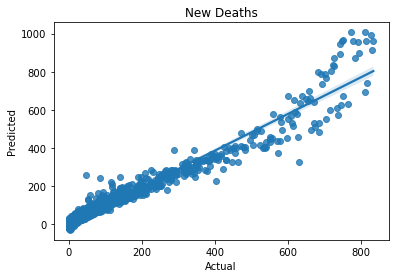

In [18]:
#Plot model of predicted vs actual with seaborn
df_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
sns.regplot(x='Actual', y='Predicted', data=df_compare).set_title('New Deaths')